In [1]:
import os
import sys
import seaborn
import pandas as pd
import torch.nn as nn
import os.path as path 
from mpl_toolkits.mplot3d import Axes3D

ROOT_PATH = path.abspath(path.join(".."))
sys.path.insert(4, os.path.join(ROOT_PATH))

from src.model.train import train_model
from src.model.evaluate import test_models
from src.model.models import SimpleCNN, ComplexCNN, DeepCNN
from src.utils import load_object, PICKLE_PATH, INTERIM_PATH, AUDIO_PATH
from src.data.prepare import split_data, build_training_data, save_training_data
from src.data.make import extract_or_load_words, request_pronunciations, save_pronunciations, build_dataframe, \
    API_KEY
from src.data.clean import remove_silence_save, audio_augmentation, pca_audio, speech_recognition_assessment, \
    detect_outliers
from src.notebook_utils import play_tones, display_tone_dist, display_duration, display_wave_plots, play_aug, \
    display_spectrogram, play_audio_length, compare_duration, play_long_audio, display_aug, display_pca_types, \
    display_outliers, play_anomalies, play_audio_quality, display_loss, compare_loss


%matplotlib inline

pd.options.mode.chained_assignment = None



## Introduction

Mandarin Chinese is a tonal language; each word has a tone label that changes its meaning. There are four commonly used tones in Chinese. The purpose of this project is to build a model to classify which tone a person is using, as good or better than native Mandarin Speakers.

Most sound recognition projects visualise data into spectrograms. Advancements in computer vision influenced this process. Spectrograms provide higher-dimensional information of the audio data, but they have weaknesses. Humans are better at detecting differences in lower frequencies. Spectrograms disregard this fact.

A Mel spectrogram is a combination of a spectrogram, and a Mel scale, transforming linear frequencies to represent sounds humans consider important. Mel spectrograms are the data I need to teach model similar to native speakers, avoiding added bias.

https://api.forvo.com/ is a website I used to request word pronunciations in Chinese. The variety of words and speakers improves the generalisation of the model.  Speech synthesis is less prone to error, but the model will be less applicable to the real world.

Audio pronunciation made from random people is bound to include error. To clean the data,  I removed excess silence, computed the PCA to remove outliers and used Speach Recognition to remove low-quality data. I sampled data with a representative tone distribution to remove added bias. 

There is tradeoff using this data cleaning method. Although the quality of the data improved, it removes nearly half of the dataset. Augmenting the data builds enough samples for this project. Through manipulating the frequencies or noise injection, I can create three times more of the dataset. Increasing the size of the data leads to a better variance of the model.

Most Chinese words include two separate tones.  I can predict the two tones separately by using multitask learning. The model can share information from the previous layers to classify the two y labels, rather than trying to predict all unique tone combinations. Using this method,  the model gets closer to performing similar to the native speakers.

To finalise the data, I converted the audio files into Mel spectrograms, storing the pixels and the two y labels into a NumPy array. Then I used a PyTorch DataLoader to convert the data into tensors. 

There are three models used in this project:
1. SimpleCNN: 5 convolutional layers with the least number of hidden units
2. ComplexCNN: 5 convolutional layers with more hidden units than the SimpleCNN
3. DeepCNN: 12 convolutional layers

All three models achieved above a 80% accuracy on both y labels on the test set. The DeepCNN performed the best — signifying a high level of feature extraction is needed for the model to perform.

## Request Data

Building a list of unique Chinese characters.

In [2]:
chinese_words = extract_or_load_words()


Word examples

In [3]:
chinese_words[:10]

['爱', '八', '爸爸', '杯子', '北京', '本', '不', '菜', '茶', '吃']

These two functions request the pronunciations and then save them.
* limit: maximum times you can request the same word from different people

Note: I can only make 500 requests per day, so I randomly sample 500 words each day.

In [4]:
mp3_urls = request_pronunciations(chinese_words, API_KEY, limit=2)
audio_list = save_pronunciations(mp3_urls)

100%|██████████| 896/896 [06:59<00:00,  2.14it/s]


Building a DataFrame and also appending the previous appended dataset.

In [5]:
audio_data = build_dataframe(audio_list)

The data frame includes information about the audio file's tone, word, and Id.

In [6]:
audio_data.head()

duraation  duration                 id  nframes   tones word
0        NaN  2.586122  audio_1d14693.wav   114048  (3, 4)   勉励
1        NaN  2.272653  audio_7310d1a.wav   100224  (3, 4)   勉励
2        NaN  2.612245  audio_bf70714.wav   115200  (2, 2)   提前
3        NaN  3.004082  audio_660f10d.wav   132480  (2, 2)   提前
4        NaN  2.220408  audio_940d96f.wav    97920  (4, 4)   救济

In [7]:
audio_data.to_pickle(PICKLE_PATH + "audio_df.pkl")

## Data Exploration


There are null values within the tone and label category, highlighting some error occurred extracting the tone.

In [8]:
audio_data = pd.read_pickle(PICKLE_PATH + "audio_df.pkl")
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2569 entries, 0 to 2568
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  2569 non-null   float64
 1   id        2569 non-null   object 
 2   nframes   2569 non-null   int64  
 3   tones     2569 non-null   object 
 4   word      2569 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 120.4+ KB


###  Tones

Most Chinese words include two characters which means the word has two seprate tones. These are the indivindual tone labels:

* Tone 1: pronounced in a high pitch
* Tone 2: a low to high pitch sound
* Tone 3: pronounced in a deep pitch
* Tone 4: a high to low pitch sound
* Tone 5: pronnonced with no tone
* Tone 6: represents there is no second character

Here are few examples of each tone:

In [9]:
play_tones(audio_data)

This confirms the dataset's tone distribution is representative of the real world.

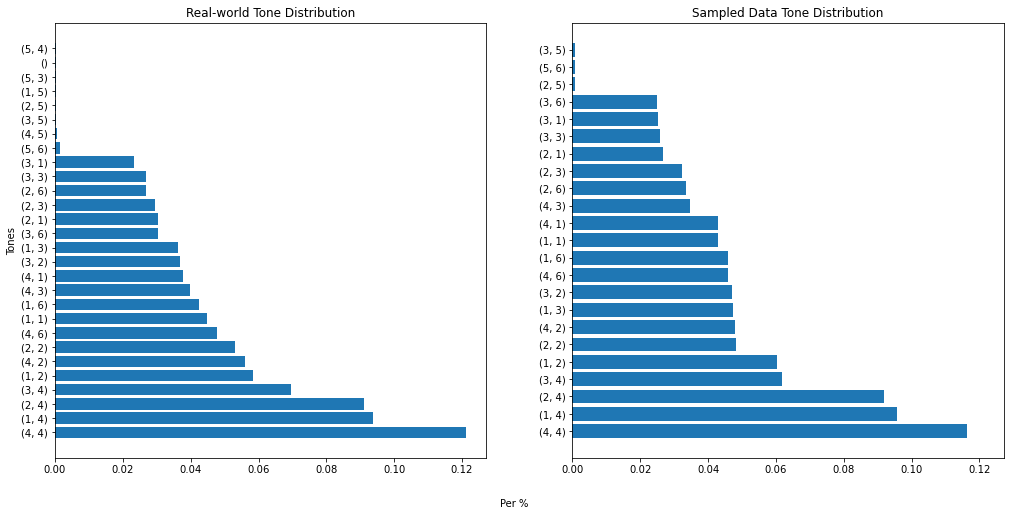

In [10]:
display_tone_dist(chinese_words, audio_data)

There are few annomlies dected in the audio duration. 

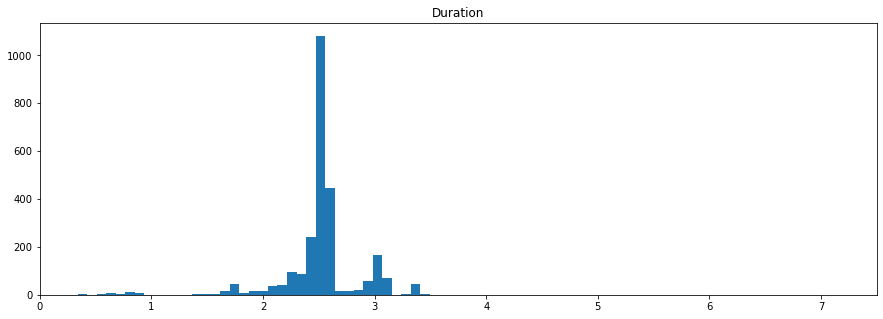

In [11]:
display_duration(audio_data)

The wave plots show that a huge portion of the audio files contain silence.

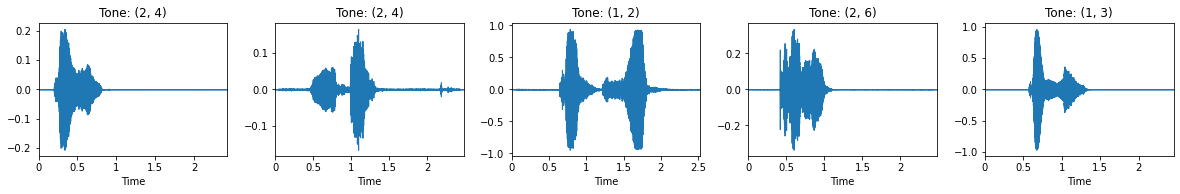

In [12]:
display_wave_plots(audio_data)

The Mel spectrograms provide more information about the audio files but difficult to interpret.

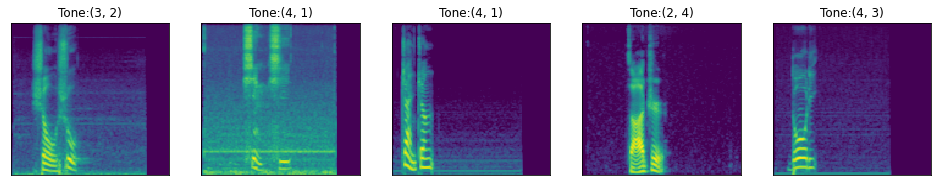

In [13]:
display_spectrogram(audio_data)

## Remove Silence

Majority of the audio files include excess silence. Removing silenceshortens the range and mean of the audio data's duration. Less padding is then required once building the Mel Spectrograms. As limits are placed on my computing resources (8GB GPU), removing silence reduces the memory of the data and training time.

Remove all null values in the data.

In [14]:
audio_data = audio_data.dropna()

A function that removes the silence from the audio files.

In [15]:
audio_data = remove_silence_save(audio_data)

100%|██████████| 2569/2569 [00:58<00:00, 43.95it/s] 


A comparison of the audio file with or without the silence removed.

In [16]:
play_audio_length(audio_data)

Word: 干, Tone: (1, 6)


After removing the silence, the duration range has decreased and has more of a normal distribution. Outliers are still visible, audio files longer than 2 seconds.

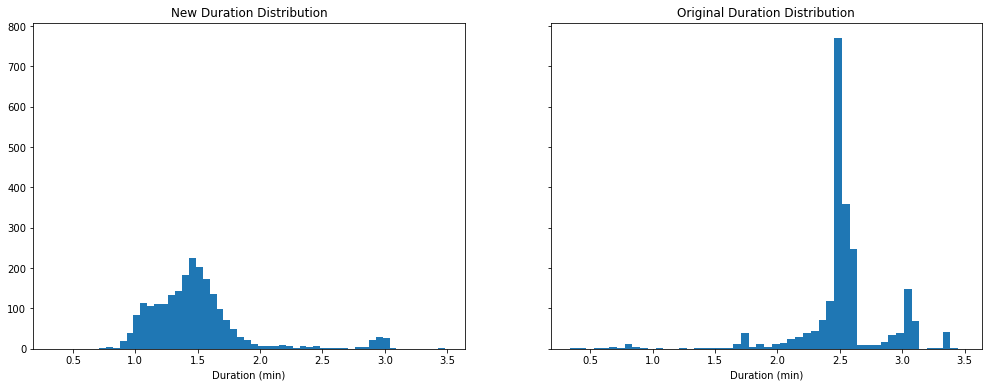

In [17]:
compare_duration(audio_data)

Audio files longer than 2 seconds tend to include more Gaussian noise; silenced was not identified, so nothing was removed.

Here are two examples of the longer audio files.

In [18]:
play_long_audio(audio_data)

Removing audio files longer than 2 seconds.

In [19]:
audio_data = audio_data[audio_data['new_duration'] < 2]

## Data Augmentation

The data cleaning process removes nearly half of the audio files. The remaining data is insufficient to prevent the model from overfitting.  Augmenting can solve this issue.

I can produce three variations of the same audio file by manipulating the frequencies, noise injection or shifting the sound. 

Here are examples of different audio types:

In [20]:
play_aug(audio_data)

There are noticeable differences within each wave plot of the same file.

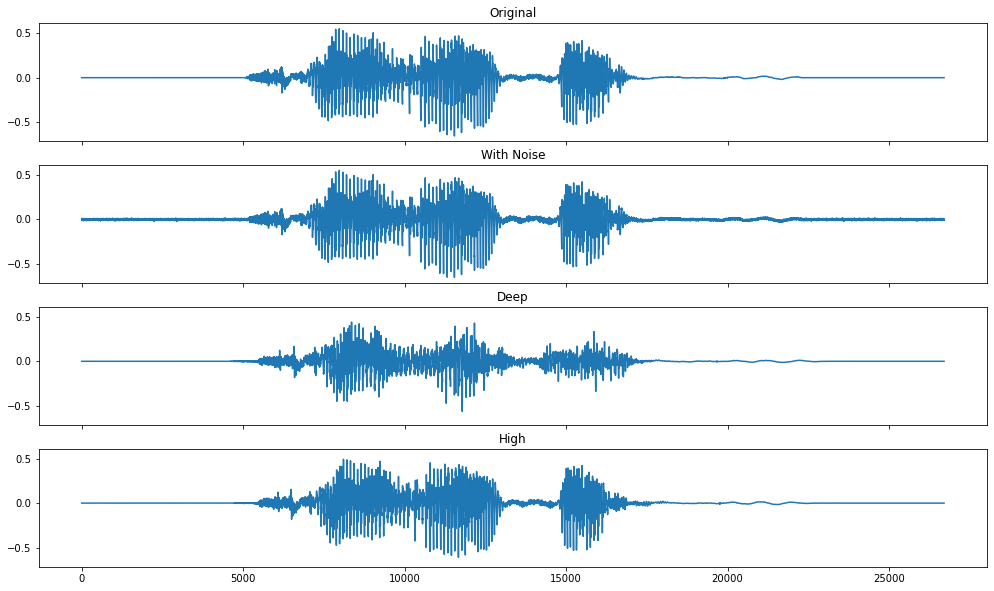

In [21]:
display_aug(audio_data)

Now there are enough samples to prevent overfitting occurring.

In [22]:
audio_data_ag = audio_augmentation(audio_data)                   

100%|██████████| 2077/2077 [01:30<00:00, 22.85it/s] 


## PCA

Principle Component Analysis allows me to reduce the dimensions of the Mel Spectrograms, plot the residuals, and then identify any outliers or clusters within the data. Then an Isolation Forest is applied to determine whether or not an observation is an outlier.

A function that computes the PCA and the Isolation Forest.

In [23]:
audio_pca = pca_audio(audio_data_ag)
audio_pca = detect_outliers(audio_pca)

100%|██████████| 8308/8308 [02:17<00:00, 60.21it/s] 


There are visible audio type clusters, especially the audio with added noise.

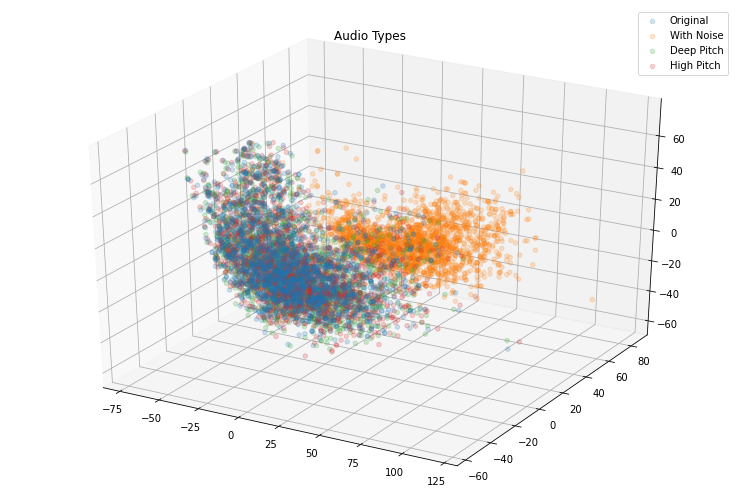

In [24]:
display_pca_types(audio_pca)   

The data set includes a few outliers.

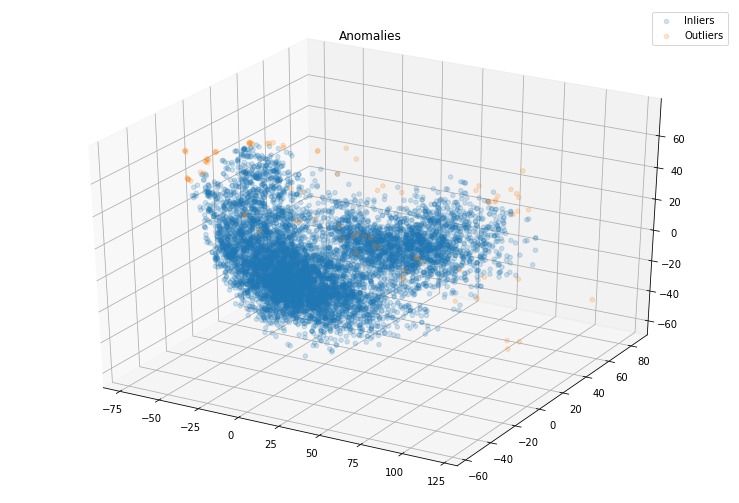

In [25]:
display_outliers(audio_pca)

Error is more common in the audio files labelled as outliers, but this is not always the case. There is not enough information retained during the PCA to make this strong assumption. 

In [26]:
play_anomalies(audio_pca)

Tone: (1, 3)	Anomaly: 1	Audio Type: HF


Tone: (1, 4)	Anomaly: -1	Audio Type: CL


I removed the outliers as they could affect model performance.

In [27]:
audio_inlier = audio_pca[audio_pca.anomaly == 1]

## Speech Recognition

Google Speech Recognition is used to detect mislabeled, incomprehensible, and inconsistent audio data.


To label the quality of the data,  I made assumptions based on the results of the transcription task:
* 0: if one of the transcripts match the word
* 1: if one of the transcript's tone matches the tone
* 2: if none of the transcripts matches the word or the tone


In [28]:
df_count = len(audio_inlier)
audio_cln = speech_recognition_assessment(audio_inlier)

100%|██████████| 8224/8224 [47:35<00:00,  2.88it/s]   


The low-quality audio files are more likely to be mislabeled or lack clarity. Using this data will confuse our model as it won't be able to separate patterns in each class.

In [29]:
play_audio_quality(audio_cln)

Tone: (1, 4)	Sound Quality: 0.0	Audio Type: CL


Tone: (3, 2)	Sound Quality: 2.0	Audio Type: WN


I only select data that have sound quality 0 or 1, removing nearly half of the augmented dataset. 

In [30]:
audio_best = audio_cln[audio_cln.sound_quality <= 1]
print(f'# Samples Removed: {df_count - len(audio_best)}')

# Samples Removed: 1538


The distribution of the tones in the dataset is close enough to the real world. I decided to keep this distribution as resampling could remove too much data.

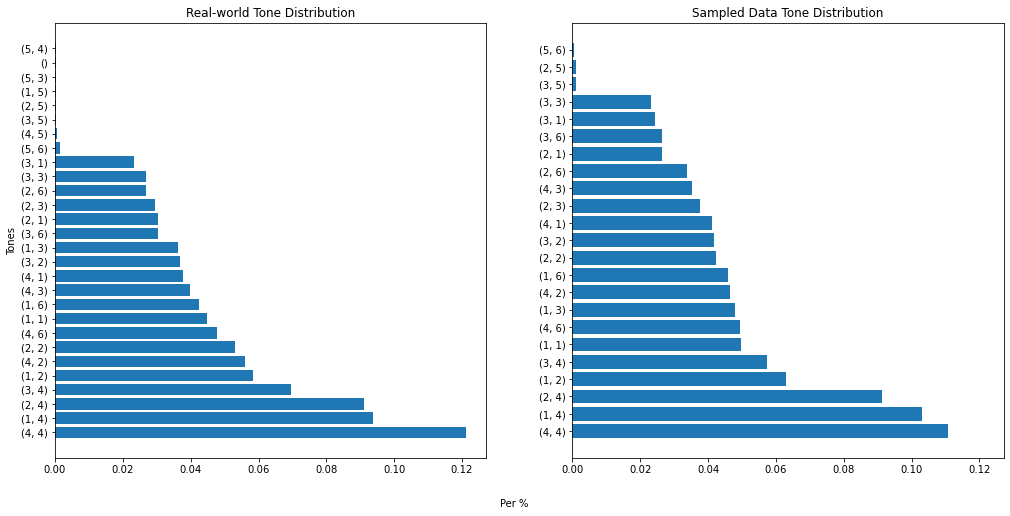

In [31]:
display_tone_dist(chinese_words, audio_best, file_path='tone_distrib2.png')

In [32]:
audio_pr = audio_best.reset_index(drop=True)

## Data Preperation

Splitting the data

In [33]:
train, valid, test = split_data(audio_pr, test_per=0.05, val_per=0.10)

# Train Size: 5684
# Valid Size: 668
# Test Size: 334


Here I build the multi-task dataset with two y labels. I convert the audio files into Mel spectrograms and then load them into PyTorch tensor. 

The duration indicates the length I will transform each audio file using padding, ensuring each spectrogram has the same dimensions. 

In [34]:
train_loader, valid_loader, test_loader = build_training_data(train, valid, test, train_batch_size=32, val_batch_size=32, test_batch_size=32, duration=2)
save_training_data(train_loader, valid_loader, test_loader)

100%|██████████| 334/334 [00:06<00:00, 49.53it/s]


## Train

There are three models of different complexities in this project. Comparing the results gives me a strong basis on ways to tune the model for optimum performance.

In [35]:
loss_func = nn.CrossEntropyLoss()
configs = {'lr_decay': False, 'epochs': 50, 'patience': 15, 'lr': 1e-04, 'optim':'adam', 'early_stop': True}
configs = pd.Series(configs)

train_loader = load_object(INTERIM_PATH + "train_loader.pkl")
valid_loader = load_object(INTERIM_PATH + "valid_loader.pkl")

### SimpleCNN

The SimpleCNN has the least number of hidden units.

In [36]:
simpleCNN = SimpleCNN()

In [37]:
train_model(configs, simpleCNN, loss_func, train_loader, valid_loader, print_info=False, print_epoch=10)

Epoch: 1/50
Train-Loss: 1.354127735569236	Valid-Loss: 0.9434049129486084
ToneA Valid-Accuracy: 0.6197604790419161	ToneB Valid Accuracy: 0.6631736526946108
Epoch: 10/50
Train-Loss: 0.03726019419918067	Valid-Loss: 0.33441286250239327
ToneA Valid-Accuracy: 0.8937125748502994	ToneB Valid Accuracy: 0.8937125748502994
Epoch: 20/50
Train-Loss: 0.0264840438305348	Valid-Loss: 0.36715868257340933
ToneA Valid-Accuracy: 0.8967065868263473	ToneB Valid Accuracy: 0.8982035928143712
Early stopping

Best val Acc: 0.902695
Min val Loss: 0.312413


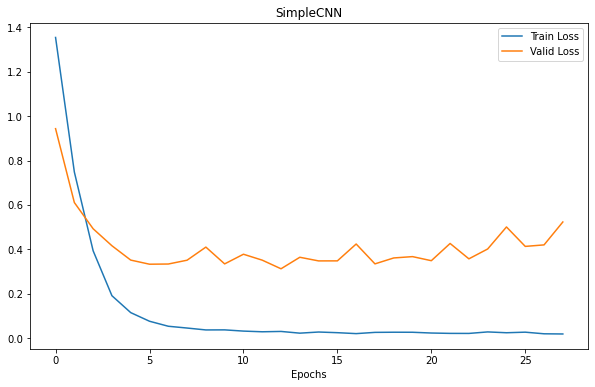

In [38]:
display_loss(simpleCNN)

### ComplexCNN

The ComplexCNN has a higher number of hidden units than the SimpleCNN but the same number of layers. Comparing the results of these two models tells me if the number of hidden units has an effect on performance. 

In [39]:
complexCNN = ComplexCNN()

In [40]:
train_model(configs, complexCNN, loss_func, train_loader, valid_loader, print_info=False, print_epoch=10)

Epoch: 1/50
Train-Loss: 1.5371730243891812	Valid-Loss: 0.9402548982983544
ToneA Valid-Accuracy: 0.6452095808383234	ToneB Valid Accuracy: 0.6646706586826348
Epoch: 10/50
Train-Loss: 0.059447076229190224	Valid-Loss: 0.3456496780826932
ToneA Valid-Accuracy: 0.8937125748502994	ToneB Valid Accuracy: 0.8802395209580839
Epoch: 20/50
Train-Loss: 0.05221525947380225	Valid-Loss: 0.3066210611945107
ToneA Valid-Accuracy: 0.8997005988023952	ToneB Valid Accuracy: 0.9011976047904192
Early stopping

Best val Acc: 0.913174
Min val Loss: 0.278108


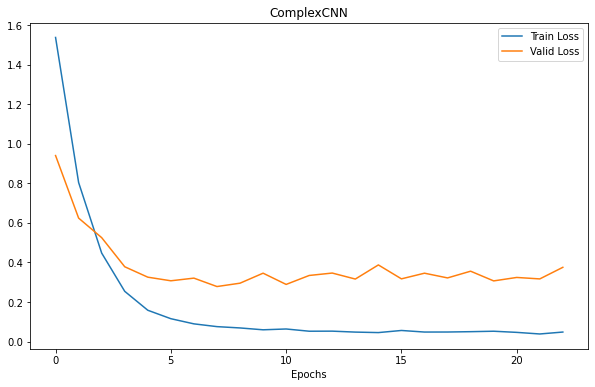

In [41]:
display_loss(complexCNN)

## DeepCNN

The DeepCNN is composed of 12 covolutional layers. Comparing the results of this model with the others will highlight whether using more convolutional layers is useful for this project.

In [42]:
deepCNN = DeepCNN()

In [43]:
train_model(configs, deepCNN, loss_func, train_loader, valid_loader, print_info=False, print_epoch=10)

Epoch: 1/50
Train-Loss: 1.2884384808915386	Valid-Loss: 1.0366604186239696
ToneA Valid-Accuracy: 0.562874251497006	ToneB Valid Accuracy: 0.6182634730538922
Epoch: 10/50
Train-Loss: 0.02235911389959327	Valid-Loss: 0.26757235913759186
ToneA Valid-Accuracy: 0.9221556886227545	ToneB Valid Accuracy: 0.9191616766467066
Epoch: 20/50
Train-Loss: 0.030009086816728616	Valid-Loss: 0.3030602444140684
ToneA Valid-Accuracy: 0.9131736526946108	ToneB Valid Accuracy: 0.9146706586826348
Epoch: 30/50
Train-Loss: 0.025800899078276825	Valid-Loss: 0.3117680194388543
ToneA Valid-Accuracy: 0.937125748502994	ToneB Valid Accuracy: 0.9311377245508982
Epoch: 40/50
Train-Loss: 0.015447917029724634	Valid-Loss: 0.17675412878660218
ToneA Valid-Accuracy: 0.9670658682634731	ToneB Valid Accuracy: 0.9565868263473054
Epoch: 50/50
Train-Loss: 0.010297267906628733	Valid-Loss: 0.2195773445779369
ToneA Valid-Accuracy: 0.9595808383233533	ToneB Valid Accuracy: 0.9446107784431138

Best val Acc: 0.961826
Min val Loss: 0.176754


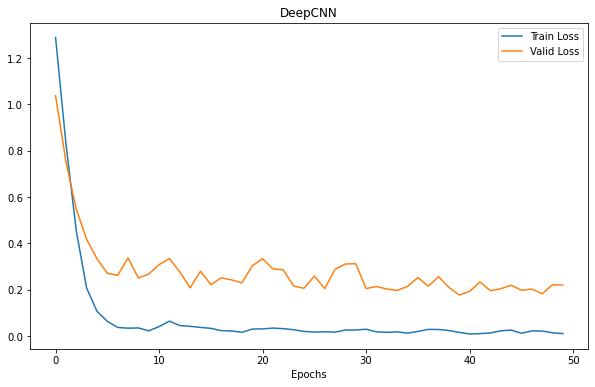

In [44]:
display_loss(deepCNN)

The deepCNN performed the best on the validation set.

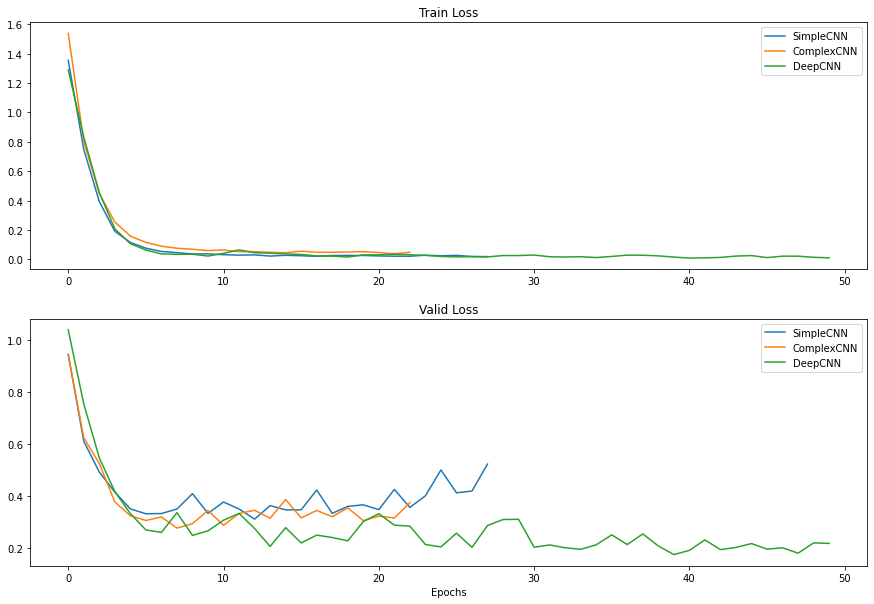

In [45]:
compare_loss(simpleCNN, complexCNN, deepCNN)

## Test Model

In [46]:
simpleCNN = SimpleCNN()
complexCNN = ComplexCNN()
deepCNN = DeepCNN()

test_loader = load_object(INTERIM_PATH + "test_loader.pkl")

In [47]:
results = test_models(test_loader, simpleCNN, complexCNN, deepCNN)


In [48]:
for result in results:
    print(result)

{'SimpleCNN': {'ToneA Acc': 0.8562874251497006, 'ToneB Acc': 0.8652694610778443, 'Avg Acc': 0.8607784431137724}}
{'ComplexCNN': {'ToneA Acc': 0.8263473053892215, 'ToneB Acc': 0.844311377245509, 'Avg Acc': 0.8353293413173652}}
{'DeepCNN': {'ToneA Acc': 0.9431137724550899, 'ToneB Acc': 0.9401197604790419, 'Avg Acc': 0.9416167664670658}}


## Conclusion


Each process taken in the data wrangling process is what leads to the high-performing models.  Data augmentation reduces the risk of overfitting. Removing outliers and speech recognition assessment improves the quality of the data. Multitask learning allows the model to learn and perform similar to native speakers. 

Achieving above 80% accuracy on each model comes close to achieving my goal for this project. But native speakers are not wrong 80% of the time. Limits placed on the request quota is one of the main things preventing me from achieving, human-level performance.